# Image reconstruction in X-ray tomography

**Authors**:

* Alexandre Zouaoui (alexandre.zouaoui@ens-paris-saclay.fr)

## X-ray tomography

We are interested in the following inverse problem:

\begin{align}
y = H \overline{x} + w
\end{align}

where $y \in \mathbb{R}^M$ are the measurements from a set of projections at different angles of a X-ray tomography, $\overline{x} \in \mathbb{R}^N$  is the sought absorption image and $w \in \mathbb{R}^M$ is the measurement noise assumed to be i.i.d. Gaussian with variance $\sigma^2$. $H$ is a sparse tomography matrix that encodes the geometry of the measurements. 

In our case $H$ models parallel projections of a 2-D object $\overline{x}$. Here the tomography measures are acquired at fixed and regularly sampled rotational positions between the sample and the detector so that $H_{mn}$ models the intersection length between the $m$-th light-ray and the $n$-th pixel. We denote by $N_\theta$ the number of different angular positions of the detector and by $L$ the linear size of the detector, hence the number of measurements are $M = L \times N_\theta$.

We study reconstruction approaches that do not require the linear system to be sufficiently determined for good results (i.e. $N_\theta \sim L$). We must then overcome the under-determinacy of the problem and make it robust to the presence of noise in the measurements.

### Imports

In [10]:
import numpy as np
from scipy.io import loadmat
from scipy import sparse
from scipy import linalg
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from itertools import product

### Style

In [11]:
sns.set_style("darkgrid")

### Paths

In [12]:
CWD = os.getcwd()
DATA_DIR = os.path.join(CWD, "data")

### Question 1

Download the projection matrix $H$ and the image $\overline{x}$ available on the website.

---

In [13]:
# Load files
x = loadmat(os.path.join(DATA_DIR, "x.mat"))["x"]
H = loadmat(os.path.join(DATA_DIR, "H.mat"))["H"]

# Squeeze x
x = x.squeeze()

# Print type and shape information
print(f"Type of x: {type(x)}")
print(f"Shape of x: {x.shape}")
print(f"Type of H: {type(H)}")
print(f"Shape of H: {H.shape}")

# Global variables setup
N = 90 * 90
M = 90 * 180

# Sanity check
assert x.shape[0] == N
assert H.shape == (M, N)

Type of x: <class 'numpy.ndarray'>
Shape of x: (8100,)
Type of H: <class 'scipy.sparse.csc.csc_matrix'>
Shape of H: (16200, 8100)


### Question 2

Construct y, according to the linear system defined above, using $\sigma = 1$.

---

In [14]:
# Set a random seed for reproducibility
np.random.seed(0)

# Noise setup
σ = 1
noise = σ ** np.random.randn(M)

# Construct y
y = H.dot(x) + noise

# Sanity check
assert noise.shape[0] == M
assert y.shape[0] == M

### Question 3

Here $N = 90 \times 90$ pixels and $M = 90 \times 180$ measurements. Display a 2D version of $x$ and a 2D version of $y$, also known as sinogram. Bare in mind that $x$ and $y$ were constructed by concatenating the flattened the columns values.

---

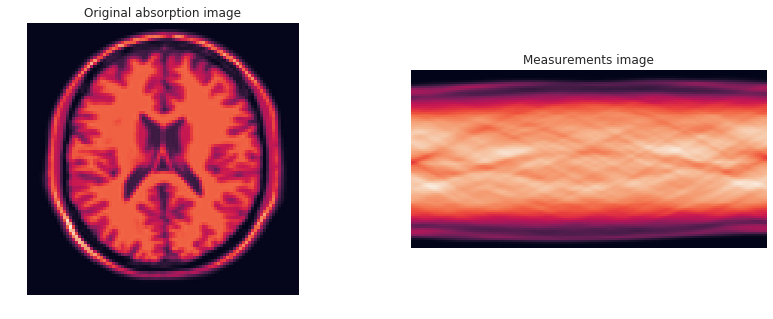

In [15]:
# Display 2D signals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Display a 2D version of x
axes[0].imshow(x.reshape((90, 90), order="F"))
axes[0].set_axis_off()
axes[0].set_title("Original absorption image");
# Display a 2D version of y
axes[1].imshow(y.reshape((90, 180), order="F"))
axes[1].set_axis_off()
axes[1].set_title("Measurements image");

## Optimization problem

An efficient strategy to address the reconstruction problem is to define $x$ as a minimizer of an appropriate cost function $f$. More specifically, we focus on the regularized least-squares criterion:

$$\forall x \in \mathbb{R}^N, \quad f(x) = \frac{1}{2} \| Hx - y \|^2 + \lambda r(x)$$

where $r$ is a regularization function incorporating a priori assumptions to guarantee the robustness of the solution with respect to noise. In order to promote images formed by smooth regions separated by sharp edges, we use:


$$\forall x \in \mathbb{R}^N, \quad r(x) = \sum_{i=1}^{2N} \phi([Gx]^{(i)})$$


where $G \in \mathbb{R}^{2N \times N}$ is a sparse matrix such that $Gx \in \mathbb{R}^{2N}$ is the concatenation of the horizontal and vertical gradients of the image, and $\phi$ is a potential function defined as:

$$\forall u \in \mathbb{R}, \quad \phi(u) = \sqrt{1 + u^2 / \delta^2}$$
with some parameter $\delta > 0$ to guarantee the differentiability of $r$. 

In the following, we will set $(\lambda, \delta) = (0.13, 0.02)$.

In [16]:
# Setup
λ = 0.13
δ = 0.02

### Question 1

Download the gradient operator $G$

---

In [17]:
# Load gradient operator
G = loadmat(os.path.join(DATA_DIR, "G.mat"))["G"]

# Print type and shape information
print(f"Type of x: {type(G)}")
print(f"Shape of x: {G.shape}")

# Sanity check
assert G.shape == (2 * N, N)

Type of x: <class 'scipy.sparse.csc.csc_matrix'>
Shape of x: (16200, 8100)


### Question 2

* Give the expression of the gradient $\nabla f$ at some point $x \in \mathbb{R}^N$. 

* Create a function which gives as an output the gradient of $f$ at some input vector $x$.

---

* We have:
$$\forall x \in \mathbb{R}^N, \quad \nabla f(x) = H^T(Hx - y) + \lambda \nabla r(x)$$


* Moreover:

\begin{align*}
\forall x \in \mathbb{R}^N, \, \forall k \in \{1, \ldots, N\}, \quad \frac{d r(x)}{d x_k}
& = \sum_{i=1}^{2N} \frac{d (\sum_{j=1}^N G_{i, j} x_j)}{d x_k} \phi'([Gx]_i) \\
& = \sum_{i=1}^{2N} G_{i, k} \phi'([Gx]_i) \\
& = \sum_{i=1}^{2N} G_{k, i}^T \phi'([Gx]_i) \\
& = \big[ G^T \big( \phi'([Gx]_i)\big)_{i \in \{1, \ldots, 2N\}} \big]_k
\end{align*}

* Therefore:

$$\forall x \in \mathbb{R}^N, \quad \nabla r(x) = G^T \big( \phi'([Gx]_i)\big)_{i \in \{1, \ldots, 2N\}}$$

* Where:

$$\forall u \in \mathbb{R}, \quad \phi'(u) = \frac{u}{\delta^2 \sqrt{1 + u^2 / \delta^2}}$$

* Finally:

$$\boxed{\forall x \in \mathbb{R}^N, \quad \nabla f(x) = H^T (Hx - y) + \lambda G^T \big( \phi'([Gx]_i)\big)_{i \in \{1, \ldots, 2N\}}}$$

In [18]:
def grad_f(x, λ=λ, δ=δ):
    """
    Compute the gradient of f (defined above)
    at some input x
    
    Parameters
    -----------
    - x : numpy.array
        Input vector
        
    - λ : float (optional)
        Relaxation parameter
        Default: 0.13
    
    - δ : float (optional)
        Differentiability parameter
        Default: 0.02
        
    Returns
    -----------
    - g : numpy.array
        Gradient output vector
    """
    
    # Compute the ϕ' part
    ϕ_grad = G.dot(x) / (δ**2 * np.sqrt(1 + G.dot(x)**2 / δ**2))

    # Compute the gradient
    grad = H.T.dot(H.dot(x) - y) + λ * G.T.dot(ϕ_grad)
    return grad

### Question 3

Show that a Lipschitz constant of $\nabla f$ is

$$L = \|H\|^2 + \frac{\lambda}{\delta^2} \|G\|^2$$

Calculate it for the $(\lambda, \delta)$ values given above. In Python we can use ``scipy.sparse.linalg.svds`` that outputs the singular values of a sparse matrix, the norm of the matrix being the maximal singular value.

---

First of all, we have:

$$\forall x \in \mathbb{R}^N, \quad \nabla^2 f (x) = H^T H + \lambda G^T G \big( \phi''([Gx]_i)\big)_{i \in \{1, \ldots, 2N\}}$$

In addition:

$$\forall u \in \mathbb{R}, \quad \frac{d^2 \phi(u)}{du^2} = \frac{1 - \frac{u^2}{\delta^2(1 + \frac{u^2}{\delta^2})}}{\delta^2 \sqrt{1 + \frac{u^2}{\delta^2}}}$$

Therefore:

$$\forall u \in \mathbb{R}, \quad \frac{d^2 \phi(u)}{du^2} \leq \frac{1}{\delta^2}$$

As a result:

$$\forall u, v \in \mathbb{R}, \quad |\phi'(u) - \phi'(v)| \leq \frac{1}{\delta^2} |u - v |$$

Combining the previous results:

$$\boxed{L = \|H\|^2 + \frac{\lambda}{\delta^2} \|G\|^2}$$

Where $\|H\|^2$ (respectively $\|G\|^2$) denotes the squared largest singular value of $H$ (respectively $G$).

In [19]:
# Compute norms
norm_H = np.max(sparse.linalg.svds(H, return_singular_vectors=False))
norm_G = np.max(sparse.linalg.svds(G, return_singular_vectors=False))
# Compute Lipschitz constant
L = (norm_H ** 2) + λ / (δ**2) * (norm_G**2)

## Optimization algorithms

### Gradient descent algorithm

#### Question 1

Create $x_0 \in \mathbb{R}^N$ a vector with all entries equal to 0. This will be our initialization for all tested algorithms.

---

In [20]:
# Create xO as the null vector
x0 = np.zeros_like(x)

#### Question 2

Implement a gradient descent algorithm to minimize $f$

---

In [21]:
# Define ϕ and f
ϕ = lambda u : np.sqrt(1 + u**2 / δ ** 2)
f = lambda x : 1 / 2 * np.sum((H.dot(x) - y)**2) + λ * np.sum(ϕ(G.dot(x)))

In [22]:
class Solver:
    """
    Generic Solver class serving as a parent class
    to GradientDescent, MM quadratic, 3MG, Block Coordinate MMQ
    
    Implements the display method that prints information
    and display both the reconstruction and the iterations evolution
    """
    def __init__(self):
        pass
    
    def solve(self, x0=x0, tol=1e-2, λ=λ, δ=δ):
        pass
    
    def display(self):
        # Display reconstruction
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        axes[0].imshow(x.reshape((90, 90), order="F"))
        axes[0].set_axis_off()
        axes[0].set_title("Original absorption image");
        axes[1].set_axis_off()
        axes[1].imshow(self.x_hat.reshape((90, 90), order="F"))
        axes[1].set_title("Reconstruction image")

        # Display iterates evolution
        plt.figure(figsize=(12, 5))
        plt.title(f"Value of $f$ along the {self.name} iterations")
        plt.xlabel("Iterations time (in seconds)")
        plt.ylabel("Value of $f$")
        plt.plot(self.iterations_time, self.f_values, 
                 linestyle="--", marker="o", linewidth=3,
                 label=f"{self.short} iterates")
        plt.yscale("log")
        plt.legend(frameon=True);
        
    def __repr__(self):
        if self.counter is None:
            raise ValueError("Cannot call print before using ``solve``")
        return f"{self.name}: {self.counter} steps in {round(self.total_time, 2)} seconds"
        
    def get_info(self):
        """
        Returns
        ----------
        - x_hat : numpy.array
            Approximation result
        - counter : int
            Number of iterations
        - iterations_time : list of float
            List of computation time at regular intervals
        - f_values : list of float
            objectif function values at regular intervals
        - total_time : float
            Total computational time
        """
        return self.x_hat, self.counter, self.iterations_time, self.f_values, self.total_time

In [23]:
class GradientDescent(Solver):
    
    def __init__(self):
        self.name = "Gradient Descent"
        self.short = "GD"
    
    def solve(self, x0=x0, tol=1e-2):
        # Setup
        self.x0 = x0
        self.tol = tol
        self.counter = 0
        self.f_values = list()
        self.iterations_time = list()
        
        # Initialization
        t0 = time.time()
        x_curr = np.copy(self.x0)
        
        # Main loop
        while np.linalg.norm(grad_f(x_curr)) > np.sqrt(N) * self.tol:
            # First order approximation update
            x_curr = x_curr - 1 / L * grad_f(x_curr)
            # Save iterates
            if self.counter % 100 == 0:
                self.f_values.append(f(x_curr))
                self.iterations_time.append(time.time() - t0)
            self.counter += 1
            
        # Compute total time in seconds
        self.total_time = time.time() - t0
        # Store solution
        self.x_hat = x_curr 

Gradient Descent: 1998 steps in 35.33 seconds
CPU times: user 35.2 s, sys: 121 ms, total: 35.4 s
Wall time: 35.4 s


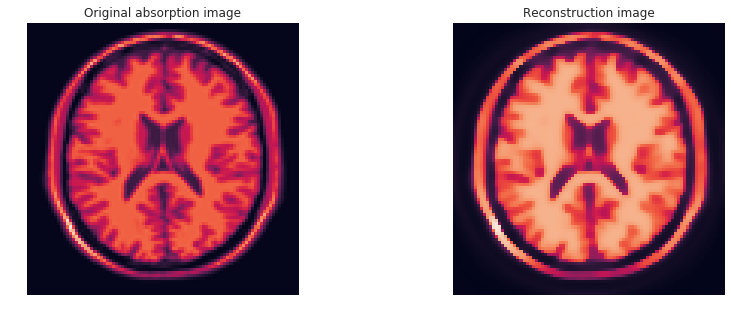

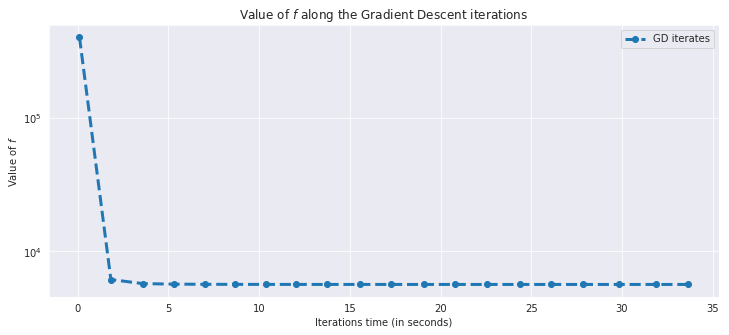

In [24]:
%%time
solver = GradientDescent()
solver.solve(x0=x0, tol=1e-2)
print(solver)
solver.display()

### Majorization Minimization (MM) quadratic algorithm

#### Question 1

Construct, for all $x \in \mathbb{R}^N$, a quadratic majorant function of $f$ at $x$.

Create a function which gives, as an output, the curvature $A(x)$ of the majorant function at an input vector $x$.

Hint: In Python, we can use ``scipy.sparse.diags(d[:, 0]).tocsc()`` to create a sparse matrix from a diagonal vector $d \in \mathbb{R}^{n \times 1}$ using the compressed sparse column (csc) format.

---

The function $r: x \in \mathbb{R}^N \mapsto r(x)$ is a separable function whose entries $r_i$ are even differentiable functions. As a result, we derive a majorant of $r_i$ using $w: u \in \mathbb{R} \mapsto \frac{r'(|u|)}{u} = \frac{1}{\delta^2 \sqrt{1 + u^2 / \delta^2}}$.

In [25]:
def curvature_A(x, λ=λ, δ=δ):
    """
    Define the curvature of the majorant function
    at input vector x
    
    Parameters
    ------------
    - x : numpy.array
        Current iterate
    
    
    Returns
    -----------
    A function that takes an input vector $v$
    and outputs $Av$
    """
    
    # Define a diagonal sparse matrix 
    d = 1 / (δ**2 * np.sqrt(1 + G.dot(x) ** 2 / δ ** 2)) 
    
    D_G = sparse.diags(d).tocsc()
    
    # Combine intermediate results using sparse operations
    return lambda v: H.T.dot(H.dot(v)) + λ * G.T.dot(D_G.dot(G.dot(v)))

#### Question 2

Deduce a MM quadratic algorithm to minimize $f$. Implement it.

Hint: To invert the majorant matrix at each iteration, use ``bicg`` from ``scipy.sparse.linalg``.

---

Since $f$ is a differentiable function from $\mathbb{R}^N$ to $\mathbb{R}$, we can derive the Majoration Minimization algorithm updates:

$$(\forall n \in \mathbb{N}) \quad x_{n+1} = x_n - \theta_n A(x_n)^{-1} \nabla f(x_n)$$

where for all $n \in \mathbb{N}, \; \theta_n \in \; ]0, 2[$. In the following, we take for all $n \in \mathbb{N}, \; \theta_n = 1$.

In [26]:
class MMQuadratic(Solver):
    
    def __init__(self):
        self.name = "MM quadratic"
        self.short = "MMQ"
    
    def solve(self, x0=x0, tol=1e-2):
        # Setup
        self.x0 = x0
        self.tol = tol
        self.counter = 0
        self.f_values = list()
        self.iterations_time = list()
        
        # Initialization
        t0 = time.time()
        x_curr = np.copy(self.x0)
        
        # Main loop
        while np.linalg.norm(grad_f(x_curr)) > np.sqrt(N) * self.tol:
            # Instanciate Linear Operator
            A = sparse.linalg.LinearOperator(shape=(N, N), 
                                             matvec=curvature_A(x_curr), 
                                             rmatvec=curvature_A(x_curr))
            # Solve Linear System
            x_curr = x_curr - sparse.linalg.bicg(A=A, b=grad_f(x_curr))[0]
            # Save iterates
            if self.counter % 10 == 0:
                self.f_values.append(f(x_curr))
                self.iterations_time.append(time.time() - t0)
            self.counter += 1
            
        # Compute total time in seconds
        self.total_time = time.time() - t0
        # Store solution
        self.x_hat = x_curr 

MM quadratic: 28 steps in 16.08 seconds
CPU times: user 16.1 s, sys: 13.9 ms, total: 16.1 s
Wall time: 16.1 s


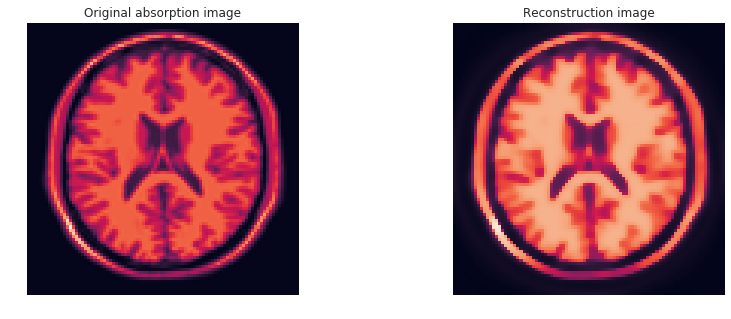

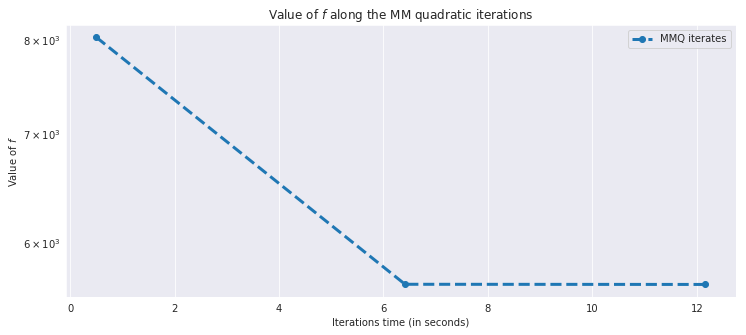

In [27]:
%%time
solver = MMQuadratic()
solver.solve(x0=x0, tol=1e-2)
print(solver)
solver.display()

### Majoration Minimization Memory Gradient (3MG) algorithm

In this section we use a subspace strategy acceleration. We focus on the 3MG approach which consists in defining the iterate $x_{k+1}$ as the minimizer of the quadratic majorant function at $x_k$ within a subspace spanned by the following directions:

$$\forall k \in \mathbb{N}, \quad D_k = \big[ - \nabla f(x_k) \; | \; x_k - x_{k-1} \big]$$

Using the convention $D_0 = - \nabla f (x_0)$. An iterate of 3MG reads:

$$\forall k \in \mathbb{N}, \quad x_{k+1} = x_k + D_k u_k$$

with

$$\forall k \in \mathbb{N}, \quad u_k = - \big( D_k^T A(x_k) D_k \big)^{\dagger} \big(D_k^T \nabla f(x_k) \big)$$

where $A(x_k) \in \mathbb{R}^{N \times N}$ is the curvature of the majorant matrix at $x_k$ and $\dagger$ denotes the pseudo-inverse operation.

#### Question 1

Implement the 3MG algorithm using ``scipy.linalg.pinv`` and be mindful of the matrix operations given the size of the matrices.

---

In [31]:
def compute_directions(x_curr, x_previous=None, first_iterate=False, λ=λ, δ=δ):
    """
    Compute the set of directions that span the acceleration subspace
    
    Parameters
    ---------
    - x_curr : numpy.array
        Current iterate
        
    - x_previous : numpy.array (optional)
        Previous iterate
        Default: None.
        
    - first_iterate : boolean (optional)
        Whether we are running the first iteration
        as it modifies the directions computation
        Default: False.
    """
    if first_iterate:
        return - grad_f(x_curr, λ=λ, δ=δ).reshape(-1, 1)
    else:
        return np.hstack((-grad_f(x_curr, λ=λ, δ=δ).reshape(-1, 1), (x_curr - x_previous).reshape(-1, 1)))

In [32]:
def compute_u(x_curr, D_curr, first_iterate=False, λ=λ, δ=δ):
    """
    Compute current directions minimizer
    
    Parameters
    ---------------
    - x_curr : numpy.array
        Current iterate
        
    - D_curr : numpy.ndarray
        Current directions
        
    - first_iterate : boolean (optional)
        Whether this is the first iterate
        Default: False.
        
    """
    
    # Intermediate computations
    tmp1 = H.dot(D_curr)
    tmp2 = G.dot(D_curr)
    # Compute Diag(Gx)
    d = 1 / (δ**2 * np.sqrt(1 + G.dot(x_curr) ** 2 / δ ** 2)) 
    D_G = sparse.diags(d).tocsc()
    # Matrix to be inverted
    tmp3 = tmp1.T.dot(tmp1) + λ + tmp2.T.dot(D_G.dot(tmp2))
    # Compute u using Moore Penrose pseudo inverse
    if first_iterate:
        return - linalg.pinv(tmp3).dot(D_curr.T.dot(grad_f(x_curr, λ=λ, δ=δ).reshape(-1, 1)))
        #return - linalg.inv(tmp3).dot(D_curr.T.dot(grad_f(x_curr).reshape(-1, 1)))
    else:
        return - linalg.pinv(tmp3).dot(D_curr.T.dot(grad_f(x_curr, λ=λ, δ=δ)))
        #return - linalg.inv(tmp3).dot(D_curr.T.dot(grad_f(x_curr)))

In [33]:
class MMMG(Solver):
    
    def __init__(self):
        self.name = "MM Memory Gradient"
        self.short = "3MG"
    
    def solve(self, x0=x0, tol=1e-2):
        # Setup
        self.x0 = x0
        self.tol = tol
        self.counter = 0
        self.f_values = list()
        self.iterations_time = list()
        
        # Initialization
        t0 = time.time()
        x_curr = np.copy(self.x0)
        
        # First iterate
        D0 = compute_directions(x_curr, first_iterate=True)
        u0 = compute_u(x_curr, D0, first_iterate=True)
        x_next = x_curr + D0.dot(u0).squeeze()
        self.counter += 1
        
        # Main loop
        while np.linalg.norm(grad_f(x_next)) > np.sqrt(N) * self.tol:
            x_previous = x_curr
            x_curr = x_next
            # Compute directions
            D_curr = compute_directions(x_curr, x_previous)
            # Compute minimizer
            u_curr = compute_u(x_curr, D_curr)
            # Next iterate using subspace strategy
            x_next = x_curr + D_curr.dot(u_curr).squeeze()

            # Store
            if self.counter % 50 == 1: # first step outside loop
                self.f_values.append(f(x_next))
                self.iterations_time.append(time.time() - t0)
            self.counter += 1
            
        # Compute total time in seconds
        self.total_time = time.time() - t0
        # Store solution
        self.x_hat = x_curr 

MM Memory Gradient: 666 steps in 37.01 seconds
CPU times: user 1min 6s, sys: 1min 13s, total: 2min 19s
Wall time: 37.1 s


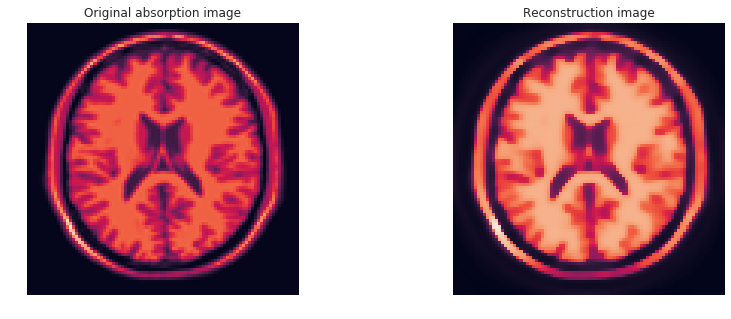

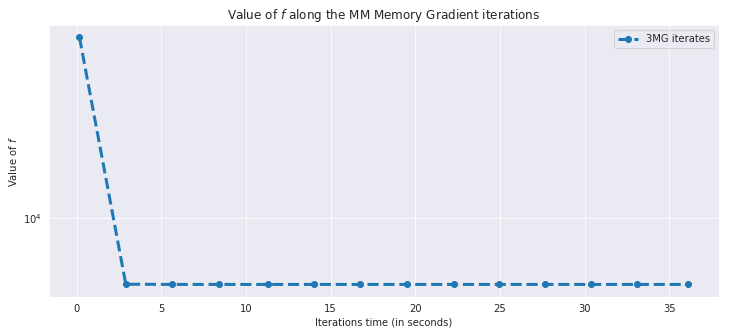

In [34]:
%%time
solver = MMMG()
solver.solve(x0=x0, tol=1e-2)
print(solver)
solver.display()

### Block-coordinate MM quadratic algorithm

Another acceleration strategy consists in applying a block alternation technique. The vector $x$ is divided into $J \geq 1$ blocks, with size $1 \leq N_j \leq N$. At each iteration $k \in \mathbb{N}$, a block index $j \subset \{1, \ldots, J\}$ is chosen, and the corresponding components of $x$, denoted $x^{(j)}$ are updated according to a MM quadratic rule. Here we will assume that the blocks are selected in a cyclic manner, that is:

$$\forall k \in \mathbb{N}, \quad j = k \text{mod} \; J + 1$$

For a given block index $j$, the corresponding pixel indexes are updated in the image:

$$n \in \mathbb{J}_j = \{(j - 1) N_j + 1, \ldots, j N_j\}$$

#### Question 1.

Create a function which gives, as an output, matrix $A_j(x) \in \mathbb{R}^{N_j \times N_j}$ containing only the lines and rows of $A(x)$ with indexes $\mathbb{J}_j$.

---



In [35]:
# Get A block
def A_block(x, j, Nj, δ=δ, λ=λ):
    """
    Compute the matrix $Aj(x) \in \mathbb{R}^{N_j \times N_j}$
    containing only the lines and rows of $A(x)$ with indexes $\mathbb{J}_j$
    
    Parameters
    ------------
    - x : numpy.array
        Vector x
        
    - j : int
        Index to select block coordinates
    
    - Nj : int
        Size of submatrix
    """
    # Select relevant block in H and G
    sub_H = H[:, (j - 1) * Nj : j * Nj]
    sub_G = G[:, (j - 1) * Nj : j * Nj]
    
    # Compute Diag(Gx)
    d = 1 / (δ**2 * np.sqrt(1 + G.dot(x) ** 2 / δ ** 2)) 
    D_G = sparse.diags(d).tocsc()
    
    return sub_H.T.dot(sub_H) + λ * sub_G.T.dot(D_G.dot(sub_G))

##### Question 2.

Deduce an implementation of a block coordinate MM quadratic algorithm for minimizing $f$.

Test if for $N_j = N / K$ with $K \in \{1, 2, 3, 5, 6, 9\}$.

---

In [36]:
class BCMMQ(Solver):
    
    def __init__(self, K):
        self.name = "Block Coordinate MMQ"
        self.short = "BCMMQ"
        self.K = K
    
    def solve(self, x0=x0, tol=1e-2):
        # Setup
        self.x0 = x0
        self.tol = tol
        self.counter = 0
        self.f_values = list()
        self.iterations_time = list()
        
        # Initialization
        t0 = time.time()
        x_curr = np.copy(self.x0)
        
        # Implement MMQ algorithm
        # Use stopping criterion
        while np.linalg.norm(grad_f(x_curr)) > np.sqrt(N) * self.tol:
            # Create block
            j = self.counter % self.K + 1
            Nj = N // self.K
            lower, upper = (j - 1) * Nj , j * Nj
            A_j = A_block(x_curr, j, N // self.K) 

            # Update block
            x_curr[lower:upper] += - sparse.linalg.bicg(A=A_j, b=grad_f(x_curr)[lower:upper])[0]

            if self.counter % 10 == 0:
                self.f_values.append(f(x_curr))
                self.iterations_time.append(time.time() - t0)
            self.counter += 1
        
        # Compute total time in seconds
        self.total_time = time.time() - t0
        # Store solution
        self.x_hat = x_curr 
        
    def display(self):
        # Display reconstruction
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        axes[0].imshow(x.reshape((90, 90), order="F"))
        axes[0].set_axis_off()
        axes[0].set_title("Original absorption image");
        axes[1].set_axis_off()
        axes[1].imshow(self.x_hat.reshape((90, 90), order="F"))
        axes[1].set_title(f"Reconstruction image (K={self.K})")
        # Display iterates
        plt.figure(figsize=(12, 5))
        plt.title(f"Value of $f$ along the iterations of {self.name} algorithm (K={self.K})")
        plt.xlabel("Iterations time (in seconds)")
        plt.ylabel("Value of $f$")
        plt.plot(self.iterations_time, self.f_values, 
                 linestyle="--", marker="o", label=f"{self.short} iterates")
        plt.yscale("log")
        plt.legend(frameon=True);
        
    def __repr__(self):
        if self.counter is None:
            raise ValueError("Cannot call print before using ``solve``")
        return (f"{self.name}: {self.counter} steps "
               f"in {round(self.total_time, 2)} seconds (K={self.K})")
    

Block Coordinate MMQ: 154 steps in 66.12 seconds (K=5)
CPU times: user 1min 4s, sys: 1.81 s, total: 1min 6s
Wall time: 1min 6s


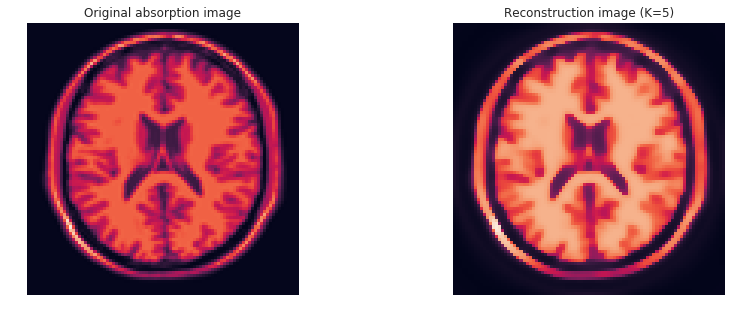

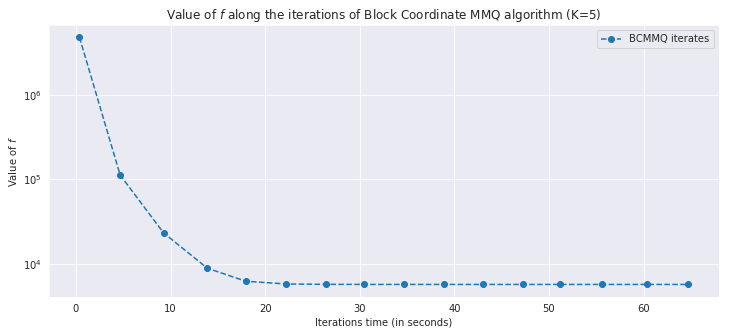

In [37]:
%%time
solver = BCMMQ(K=5)
solver.solve(x0=x0, tol=1e-2)
print(solver)
solver.display()

Block Coordinate MMQ: 98 steps in 40.16 seconds (K=5)
Block Coordinate MMQ: 119 steps in 34.47 seconds (K=6)
Block Coordinate MMQ: 171 steps in 25.12 seconds (K=9)


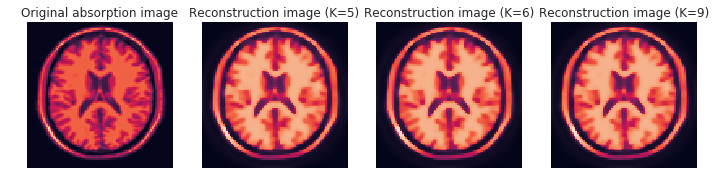

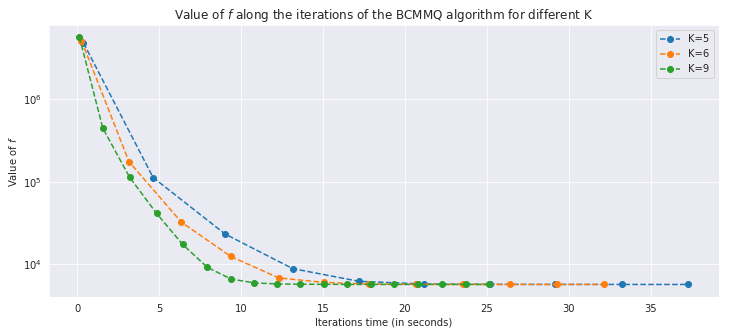

In [38]:
# Setup
K_range = [5, 6, 9] # I was getting MemoryError using K=1 or K=2 or K=3
reconstructions = list()
computation_times = list()
f_iterates = list()

for K in K_range:
    solver = BCMMQ(K=K)
    solver.solve(x0=x0, tol=1e-1)
    print(solver)
    x_hat, _ , iter_time, f_values, _ = solver.get_info()
    reconstructions.append(x_hat)
    computation_times.append(iter_time)
    f_iterates.append(f_values)
    
# Grid plot for reconstruction images
fig, axes = plt.subplots(1, len(K_range) + 1, figsize=(12, 5))
axes[0].imshow(x.reshape((90, 90), order="F"))
axes[0].set_axis_off()
axes[0].set_title("Original absorption image");
for i in range(1, len(K_range) + 1):
    axes[i].imshow(reconstructions[i - 1].reshape((90, 90), order="F"))
    axes[i].set_axis_off()
    axes[i].set_title(f"Reconstruction image (K={K_range[i - 1]})")
    
# Single plot for iterates evolution
plt.figure(figsize=(12, 5))
plt.title(f"Value of $f$ along the iterations of the BCMMQ algorithm for different K")
plt.xlabel("Iterations time (in seconds)")
plt.ylabel("Value of $f$")
for i in range(len(K_range)):
    plt.plot(computation_times[i], f_iterates[i], 
         linestyle="--", marker="o", label=f"K={K_range[i]}")
plt.yscale("log")
plt.legend(frameon=True);

**Comment:**

* It looks like the higher ``K`` is, faster is the convergence. In the last section, we will evaluate the Block Coordinate MM Quadratic algorithm using ``K=9``.

### 3.5 Parallel MM quadratic algorithm (Bonus)

### 3.6 Comparison of the methods

#### Question 1.

Create a function that computes the value of the criterion f along the iterations of the algorithm

---

We did that previously using ``f = lambda x : 1 / 2 * np.sum((H.dot(x) - y)**2) + λ * np.sum(ϕ(G.dot(x)))`` 

where $\phi$ is defined as ``ϕ = lambda u : np.sqrt(1 + u**2 / δ ** 2)``

#### Question 2.

We will consider that the convergence is reached when the following stopping criterion is fulfilled:

$$\|\nabla f(x_k) \| \leq \sqrt{N} \times 10^{-4}$$

* What is the required time for each method to achieve this condition?
* For each method, plot the evolution of $\big(f(x_k)\big)_{k \in \mathbb{N}}$ until the stopping criterion is satisfied.

---

Gradient Descent: 5081 steps in 91.3 seconds
MM quadratic: 69 steps in 40.36 seconds
MM Memory Gradient: 2019 steps in 122.81 seconds
Block Coordinate MMQ: 647 steps in 97.01 seconds (K=9)
----------
Sorted convergence times
1) MMQ in 40.36s
2) GD in 91.3s
3) BCMMQ in 97.01s
4) 3MG in 122.81s
----------


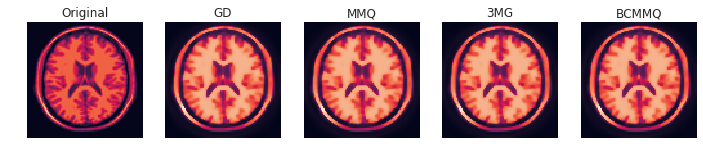

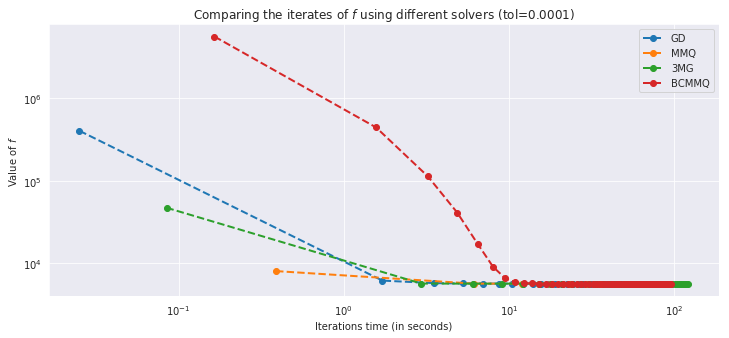

In [39]:
# Setup
tol=1e-4
solvers = [GradientDescent(),
           MMQuadratic(),
           MMMG(),
           BCMMQ(K=9)]

reconstructions = list()
iterates_times = list()
iterates_values = list()
short_names = list()
total_times = dict()

# Loop over solvers
for solver in solvers:
    solver.solve(x0=x0, tol=tol)
    print(solver)
    x_hat, _ , iter_time, f_values, total_time = solver.get_info()
    # Store results
    reconstructions.append(x_hat)
    iterates_times.append(iter_time)
    iterates_values.append(f_values)
    short_names.append(solver.short)
    total_times[solver.short] = total_time
    
# Grid plot for reconstruction images
fig, axes = plt.subplots(1, len(solvers) + 1, figsize=(12, 5))
axes[0].imshow(x.reshape((90, 90), order="F"))
axes[0].set_axis_off()
axes[0].set_title("Original");
for i in range(1, len(solvers) + 1):
    axes[i].imshow(reconstructions[i - 1].reshape((90, 90), order="F"))
    axes[i].set_axis_off()
    axes[i].set_title(f"{short_names[i - 1]}")
    
# Single plot for iterates evolution
plt.figure(figsize=(12, 5))
plt.title(f"Comparing the iterates of $f$ using different solvers (tol={tol})")
plt.xlabel("Iterations time (in seconds)")
plt.ylabel("Value of $f$")
for i in range(len(solvers)):
    plt.plot(iterates_times[i], iterates_values[i], 
        linewidth=2, linestyle="--",
        marker="o", markersize=6, 
        label=f"{short_names[i]}")
plt.yscale("log")
plt.xscale("log")
plt.legend(frameon=True);

# Print sorted convergence times
print("-"*10)
print("Sorted convergence times")
for i, solver in enumerate(sorted(total_times, key=total_times.get)):
    print(f"{i+1}) {solver} in {round(total_times[solver], 2)}s")
print("-"*10)

#### Question 3.

The Signal to Noise Ratio (SNR) of a restored image $\hat{x}$ is defined as:

$$\text{SNR} = 10 \log_{10} \big( \frac{\|\overline{x}\|^2}{\|\overline{x} - \hat{x}\|^2} \big)$$

* Using the fastest method, look for the parameters $(\lambda, \delta)$ that optimize the SNR.

---

Let us redefine our ``MMQuadratic`` solver so that we can incorporate $\lambda$ and $\delta$ seamlessly.

In [40]:
class MMQuadraticFinal(Solver):
    
    def __init__(self):
        self.name = "MM quadratic"
        self.short = "MMQ"
    
    def solve(self, x0=x0, tol=1e-2, λ=λ, δ=δ):
        # Setup
        self.x0 = x0
        self.tol = tol
        self.counter = 0
        self.f_values = list()
        self.iterations_time = list()
        
        # Redefine f
        ϕ = lambda u : np.sqrt(1 + u**2 / δ ** 2)
        f = lambda x : 1 / 2 * np.sum((H.dot(x) - y)**2) + λ * np.sum(ϕ(G.dot(x)))
        
        # Initialization
        t0 = time.time()
        x_curr = np.copy(self.x0)
        
        # Main loop
        while np.linalg.norm(grad_f(x_curr, λ=λ, δ=δ)) > np.sqrt(N) * self.tol:
            # Instanciate Linear Operator
            A = sparse.linalg.LinearOperator(shape=(N, N), 
                                             matvec=curvature_A(x_curr, λ=λ, δ=δ), 
                                             rmatvec=curvature_A(x_curr, λ=λ, δ=δ))
            # Solve Linear System
            x_curr = x_curr - sparse.linalg.bicg(A=A, b=grad_f(x_curr, λ=λ, δ=δ))[0]
            # Save iterates
            if self.counter % 10 == 0:
                self.f_values.append(f(x_curr))
                self.iterations_time.append(time.time() - t0)
            self.counter += 1
            
        # Compute total time in seconds
        self.total_time = time.time() - t0
        # Store solution
        self.x_hat = x_curr

------------------------------
Run 1/16: λ=0.5, δ=0.5
New best: SNR=26.9196 (λ=0.5, δ=0.5)
------------------------------
Run 2/16: λ=0.5, δ=1.0
New best: SNR=27.0043 (λ=0.5, δ=1.0)
------------------------------
Run 3/16: λ=0.5, δ=1.5
------------------------------
Run 4/16: λ=0.5, δ=2.0
------------------------------
Run 5/16: λ=1.0, δ=0.5
------------------------------
Run 6/16: λ=1.0, δ=1.0
New best: SNR=27.0119 (λ=1.0, δ=1.0)
------------------------------
Run 7/16: λ=1.0, δ=1.5
------------------------------
Run 8/16: λ=1.0, δ=2.0
------------------------------
Run 9/16: λ=1.5, δ=0.5
------------------------------
Run 10/16: λ=1.5, δ=1.0
------------------------------
Run 11/16: λ=1.5, δ=1.5
New best: SNR=27.0146 (λ=1.5, δ=1.5)
------------------------------
Run 12/16: λ=1.5, δ=2.0
------------------------------
Run 13/16: λ=2.0, δ=0.5
------------------------------
Run 14/16: λ=2.0, δ=1.0
------------------------------
Run 15/16: λ=2.0, δ=1.5
------------------------------
Run 1

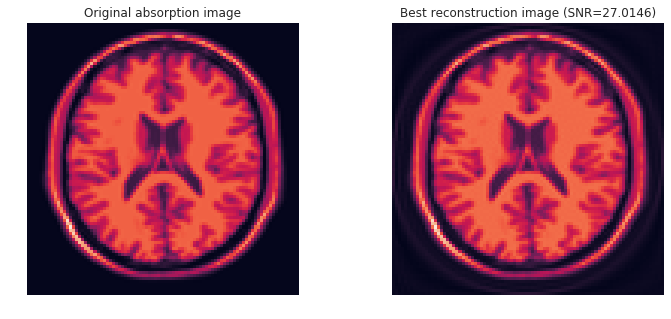

In [41]:
%%time
# Compute the Signal to Noise Ratio between restored and original images
SNR = lambda x_hat : 10 * np.log10(np.sum(x ** 2) / np.sum((x - x_hat) ** 2))

# Setup
tol = 1e-3
λ_range = np.linspace(0.5, 2, 4, endpoint=True)
δ_range = np.linspace(0.5, 2, 4, endpoint=True)

settings = list(product(λ_range, δ_range))
n_settings = len(settings)

best_SNR = - np.inf
best_approx = None
best_λ = None
best_δ = None

solver = MMQuadraticFinal()

# Main loop
for i, setup in enumerate(settings):
    λ, δ = setup
    print("-"*30)
    print(f"Run {i+1}/{n_settings}: λ={λ}, δ={δ}")
    solver.solve(x0=x0, tol=tol, λ=λ, δ=δ)
    approx = solver.x_hat
    score = SNR(approx)
    
    # Update if new print
    if score > best_SNR:
        best_SNR = score
        best_approx = approx
        best_λ = λ
        best_δ = δ
        print(f"New best: SNR={round(best_SNR, 4)} (λ={best_λ}, δ={best_δ})")

print(f"Best SNR: {round(best_SNR, 4)} using λ={best_λ}, δ={best_δ}")

# Display reconstruction
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(x.reshape((90, 90), order="F"))
axes[0].set_axis_off()
axes[0].set_title("Original absorption image")
axes[1].set_axis_off()
axes[1].imshow(best_approx.reshape((90, 90), order="F"))
axes[1].set_title(f"Best reconstruction image (SNR={round(best_SNR, 4)})");

**Comment:**

* We recover nicely the details compared to previous approximations that were using different values for $\lambda$ and $\delta$.